In [1]:
# attemp on HW1_2_1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pdb

In [2]:
device = torch.device("cuda:0")

In [3]:
data = np.load('distribution.npy')

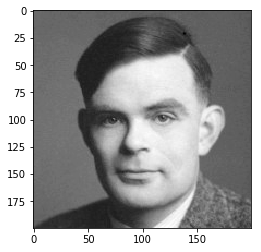

In [4]:
plt.imshow(data, cmap='gray')

In [5]:
# check that it's a probability distribution (the overall data sums to one)
np.sum(data)

1.0

How to sample from it?
From https://github.com/ikrets/CS294-158-homeworks/blob/master/HW1_2_1.ipynb, it's possible to sample $N$ samples in a given range $[0...M-1]$ from a given 1D distribution

In [6]:
# samples 100000 samples between 0 and 200*200-1 from the given distribution p
samples = np.random.choice(200 * 200, p=data.reshape(-1), size=100000)

# convert each sample to 2D:
x = samples // 200
y = samples % 200
samples = np.stack([x, y], axis=1)

In [7]:
train, valid = samples[:np.int32(0.8 * len(samples))], samples[np.int32(0.8 * len(samples)):]
print('train.shape = ', train.shape)
print('valid.shape = ', valid.shape)

train.shape =  (80000, 2)
valid.shape =  (20000, 2)


In [8]:
# calculate histogram
def hist2d(data, width, height):
    
    # init histogram
    hist = np.zeros((height, width), dtype=np.int32)
    
    # compute histogram
    for i in range(len(data)):
        hist[data[i, 0], data[i, 1]] += 1
        
    return hist

In [9]:
def one_hot(x, class_count):
    return torch.eye(class_count)[x,:]

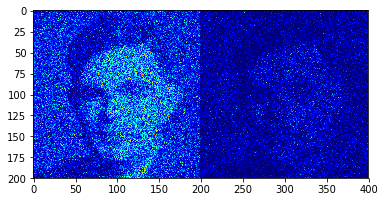

In [10]:
#visualize this
train_valid = np.concatenate((hist2d(train, 200, 200), hist2d(valid, 200, 200)), axis=1)

# plot train + valid image
plt.imshow(train_valid, cmap='jet')

Ok, the problem here is that a pixel is a joint distribution $p(x_2, x_1)$. Using bayes rule we can split this distribution as: $p(x_2, x_1) = p(x_2|x_1) p(x_1)$. 

So, We have two distributions: $p(x_1)$ and $p(x_2 | x_1)$ where $p(x_2, x_1) = p(x_2|x_1) p(x_1)$. 

The probability $p(x_1) == p_\theta(x_1)$ - which is the probability of observing $x_1$ - can be calculated using softmax formula:  $\exp(\theta) / \sum_i(exp(\theta_i))$.
Actually, $p_\theta(x_1)$ is the probability of observing $x_1$ parametrized by $\theta$
$$
p_\theta(x_1) = \frac{\exp(\theta)}{\sum_i exp(\theta_i)}
$$

How to calculate $p(x_2 | x_1)$ - the probability of observing $x_2$ given $x_1$?
In fact we can parametrize $p(x_2 | x_1)$ by $\theta$ such that $p(x_2 | x_1) == p_\theta(x_2 | x_1)$

$p_\theta(x_2 | x_1)$ can be computed by a dense network parametrized by $\theta$ that takes as input the training data $x_1$ and produces $p_\theta(x_2 | x_1)$

So, finally, we need to find $\theta$ such that $p_\theta(x_2, x_1) = p_\theta(x_2|x_1)p_\theta(x_1)$ is maximized - this is the same as maximizing the log likelihood $\hat{\theta} = argmax_\theta p_\theta(x_2|x_1)p_\theta(x_1)$-  or equivalently
minimize the log likelihood:
$$
\hat{\theta} = argmin_{\theta}(-\log(p_\theta(x_2|x_1)p_\theta(x_1)))
$$

Be aware that $x_2$ must depends on $x_1$ only.

In [11]:
# The network bellow calculate p(x2 | x1)
# learning rate
class Nade(nn.Module):
    def __init__(self, n_samples):
        super(Nade, self).__init__()
        self.fc1  = nn.Linear(in_features=n_samples, out_features=n_samples, bias=True)
        # torch.nn.init.xavier_normal_(self.fc1.weight)
        
        self.fc2  = nn.Linear(in_features=n_samples, out_features=n_samples, bias=True)
        # torch.nn.init.xavier_normal_(self.fc2.weight)
        
        self.drop = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.fc1(x)                
        x = self.drop(x)
        x = self.fc2(x)                
        return F.log_softmax(x)

In [16]:
# data loaders
BATCH_SIZE = 10
NUM_EPOCHS = 5
SAMPLE_SIZE = 200
learning_rate = 5.0e-4
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, shuffle=False)

model = Nade(SAMPLE_SIZE).to(device)

# training loop
1. grab a batch
2. forward:
   calculate p(x1): p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
   calculate p(x2 | x1): nade(x1)
3. calculate the loss: 
   calculate loss = sum(-ln(p(x2 | x1) * p(x1)) / n_samples
4. zero gradients
5. backward: loss.backward()
6. update gradients ~ accumulate (no grads)
7. goto 1.

In [17]:
# init thetas + train_loss vector
def train_validate(model, thetas, train_loader, valid_loader, num_epochs, sample_size, device):        
    
    optimizer = torch.optim.Adam([thetas] + list(model.parameters()), lr=0.001)
                        
    train_loss = []
    
    valid_loss = []
    iteration = 0
    for epoch in range(num_epochs):
      
        for idx, batch in enumerate(train_loader):
            
            model.train()
                      
            # TRAINING            
            x1, x2 = batch[:,0], batch[:,1]
            
            # forward pass            
            p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))                        
            log_p_x2_x1 = model(one_hot(x1, sample_size).to(device))
            
            # calculate losses
            loss1 = -torch.mean(torch.log(torch.gather(p_x1, 0, x1)))
            loss2 = -torch.mean(torch.gather(log_p_x2_x1, 1, x2[...,None].to(device)))
            
            # zero gradients
            optimizer.zero_grad()
            
            # calculate gradients
            loss1.backward()
            loss2.backward()
                        
            # update weights
            optimizer.step()
            
            # accumulate losses
            train_loss.append((loss1 + loss2).item() * np.log2(np.e))
            
            iteration += 1
            
            # VALIDATION
            if iteration % 100 == 0:
                with torch.no_grad():

                    model.eval()

                    batch  = next(iter(valid_loader))

                    x1, x2 = batch[:,0], batch[:,1]      

                    p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
                    log_p_x2_x1 = model(one_hot(x1, sample_size).to(device))

                    loss1 = -torch.mean(torch.log(torch.gather(p_x1, 0, x1)))
                    loss2 = -torch.mean(torch.gather(log_p_x2_x1, 1, x2[...,None].to(device)))

                    loss = loss1 + loss2

                    valid_loss.append(loss * np.log2(np.e))
                
    print('iterations = ', iteration)    
    return train_loss, valid_loss


In [18]:
# init parameters of p(x1) - thetas must be of size SAMPLE_SIZE!!!!
thetas = torch.zeros(SAMPLE_SIZE, dtype=torch.float32, requires_grad=True)

# calculate parameters of p(x1) and p(x2 | x1)
train_loss, valid_loss = train_validate(model, thetas, train_loader, valid_loader, NUM_EPOCHS, SAMPLE_SIZE, device)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


iterations =  40000


Text(0, 0.5, 'loss')

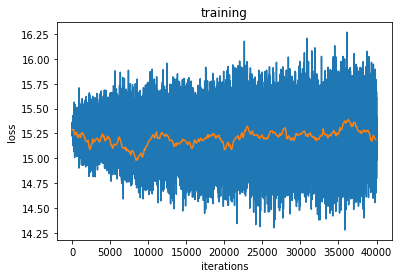

In [19]:
plt.plot(np.arange(len(train_loss)), np.array(train_loss), label='train')
plt.plot(np.arange(0, len(valid_loss) * 100, 100), np.array(valid_loss) , label='valid')
plt.title('training')
plt.xlabel('iterations')
plt.ylabel('loss')

In [33]:
# compose the total probability: p(x1, x2) = p(x2 | x1) * p(x1)
prob = torch.zeros(SAMPLE_SIZE, SAMPLE_SIZE)
for x1 in range(SAMPLE_SIZE):
    for x2 in range(SAMPLE_SIZE):
        with torch.no_grad():
            model.eval() # not sure about that
            p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
            log_p_x2_x1 = model(one_hot(x1, SAMPLE_SIZE).to(device))    
            prob[x1, x2] = torch.exp(log_p_x2_x1[x2]) * p_x1[x1]
    

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
# estimated 
prob = prob.numpy()
prob

array([[2.7285201e-05, 2.8117200e-05, 1.2142304e-05, ..., 1.8200364e-05,
        1.2622158e-05, 1.9000128e-05],
       [9.8838291e-06, 1.4372708e-05, 1.6928505e-05, ..., 1.5321819e-05,
        1.7481070e-05, 1.7476195e-05],
       [1.9135206e-05, 1.5886875e-05, 1.2727888e-05, ..., 2.8944127e-05,
        2.3269929e-05, 1.5098454e-05],
       ...,
       [1.1442187e-05, 2.8241604e-05, 2.1349722e-05, ..., 1.3130198e-05,
        1.6184387e-05, 1.1627691e-05],
       [9.2996079e-06, 9.7843149e-06, 1.5641435e-05, ..., 1.4188020e-05,
        8.6874161e-06, 1.7774037e-05],
       [1.5595228e-05, 1.3633920e-05, 1.7718343e-05, ..., 1.2560970e-05,
        1.5344929e-05, 8.0664686e-06]], dtype=float32)

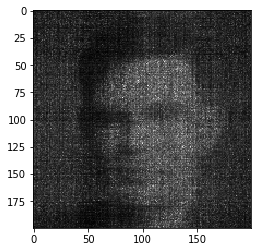

In [35]:
plt.imshow(prob, cmap='gray')

In [38]:
# sample from the model distribution
def sample_from_model(count):
    samples = np.random.choice(SAMPLE_SIZE * SAMPLE_SIZE, p=prob.reshape(-1), size=count)
    return np.stack([samples // SAMPLE_SIZE, samples % SAMPLE_SIZE], axis=1)

In [39]:
s = sample_from_model(10000000)

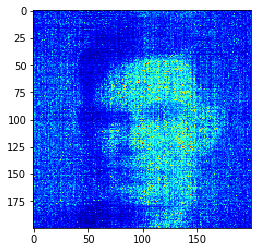

In [41]:
# build histogram
plt.imshow(hist2d(s, SAMPLE_SIZE, SAMPLE_SIZE), cmap='jet')

In [ ]:
# TODO: do the same without one hot encoding - and check the results